# Fetching & Loading Raw Data

In [157]:
import os
import random
import numpy as np
import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
from sklearn.cluster import KMeans
from sklearn import metrics
from datetime import datetime
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

In [158]:
#Defining list of stock tickers we are fetching data for -  30 tickers each for 4 different sectors
Stocks = [
    ### Computer and Technology
    "TSM", "ORCL", "CRM", "VZ", "IBM", "SPOT", "NOW", "T", "DELL", "ANET", "RELX", "APH", "SHOP", "INFY", "MSI", "AMX", "CARR", "TEL", "SNOW", "AME", "MSCI", "SE", "A", "STM", "VRT", "HPQ", "GLW", "FICO", "GRMN", "HUBS",
    ### Oil and Energy
    "XOM", "CVX", "SHEL", "TTE", "COP", "BP", "EQNR", "CNQ", "ENB", "EOG", "SLB", "MPC", "EPD", "PSX", "OXY", "E", "ET", "SU", "VLO", "WMB", "PBR", "HES", "OKE", "KMI", "MPLX", "CVE", "TRP", "LNG", "HAL", "DVN",
    ### Healthcare
    "LLY", "NVO", "UNH", "JNJ", "MRK", "ABBV", "TMO", "NUS", "ABT", "PFE", "SYK", "ELV", "BSX", "MDT", "CI", "GSK", "HCA", "BMY", "ZTS", "MCK", "BDX", "EW", "COR", "AMG", "HUM", "TAK", "IQV", "GMED", "CNC", "RMD",
    ### Finance
    "BMO", "USB", "JPM", "CME", "WFC", "BRK-B", "HSBC", "MS", "MA", "GS", "MUFG", "SCHW", "PYPL", "PGR", "ING", "BLK", "CB", "HDB", "PLD", "MMC", "TD", "IBN", "AMT", "KKR", "SMFG", "BX", "V", "ICE", "MCO", "BN", "APO"
]

#Define the date range: 5 year period 
start_date = '2021-01-01'
end_date = '2023-12-31'

#Dictionary to store the adjusted close price for each stock
stocks_adj_close = {}

#Looping through each ticker to fetch the adjusted close price
for stock in Stocks:
    stock_data = yf.Ticker(stock)
    historical_data = stock_data.history(start=start_date, end=end_date, interval="1d")
    #Ensure that 'Adj Close' column is available
    if 'Adj Close' in historical_data.columns:
        stocks_adj_close[stock] = historical_data['Adj Close']
    else:
        stocks_adj_close[stock] = historical_data['Close']  # Fallback to 'Close' if 'Adj Close' is not available

#Combining all the series into a single dataframe

data = pd.DataFrame(stocks_adj_close)
data.index = pd.to_datetime(data.index).strftime('%Y-%m-%d')

# Resetting the index to prepare for multi-indexing
data.reset_index(inplace=True)
data.rename(columns={'index': 'Date'}, inplace=True)

# Melting the DataFrame to long format for multi-indexing
data = data.melt(id_vars=['Date'], var_name='Ticker', value_name='Adj Close')

# Pivoting the DataFrame back to wide format with multi-index
data = data.pivot_table(index=['Date'], columns=['Ticker'], values='Adj Close')

# Setting multi-index
data.columns.name = 'ticker'

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)  # None means unlimited rows
pd.set_option('display.max_columns', None)  # None means unlimited columns

#Displaying the resulting dataframe



In [159]:
#saving the data into CSV file
data.to_csv('30_Stocks_4_Sectors')

# Exploring Stored Data 

In [160]:
#main statistics for post clustering 
pd.set_option('display.precision', 3)
data.describe().T.head(10)

,count,mean,std,min,25%,50%,75%,max
ticker,,,,,,,,
A,753.0,133.510,15.224,100.835,121.397,131.175,146.168,176.085
ABBV,753.0,127.214,20.345,89.663,104.662,133.524,143.527,160.493
ABT,753.0,108.518,8.837,89.313,102.148,107.814,113.959,135.071
AME,753.0,134.368,13.175,105.912,125.119,134.120,142.719,164.864
AMG,753.0,144.695,17.446,99.017,131.976,143.200,159.210,190.197
AMT,753.0,218.050,29.951,153.497,193.391,215.734,244.211,280.844
AMX,753.0,17.607,2.512,11.781,16.421,17.852,19.506,22.337
ANET,753.0,127.065,39.255,66.957,93.738,122.550,146.840,238.810
APH,753.0,74.800,7.934,58.146,68.249,74.906,79.768,99.290


# Preparing Stock Data For Clustering

In [161]:
#Performing checks to see if there are any NaN values 

# Check if there are any NaN values in the DataFrame
has_nan = data.isnull().values.any()
print(f"DataFrame contains NaN values: {has_nan}")

# Count the total number of NaN values
total_nan = data.isnull().sum().sum()
print(f"Total number of NaN values: {total_nan}")


# Check for NaN values in each ticker
nan_per_ticker = data.isnull().sum(axis=0)
print("Number of NaN values in each ticker:\n", nan_per_ticker)

# Get tickers with NaN values
tickers_with_nan = nan_per_ticker[nan_per_ticker > 0].index.tolist()
print("Tickers with NaN values:\n", tickers_with_nan)

# Display rows that contain NaN values
rows_with_nan = data[data.isnull().any(axis=1)]
print("Rows with NaN values:\n", rows_with_nan)


DataFrame contains NaN values: False
Total number of NaN values: 0
Number of NaN values in each ticker:
 ticker
A        0
ABBV     0
ABT      0
AME      0
AMG      0
AMT      0
AMX      0
ANET     0
APH      0
APO      0
BDX      0
BLK      0
BMO      0
BMY      0
BN       0
BP       0
BRK-B    0
BSX      0
BX       0
CARR     0
CB       0
CI       0
CME      0
CNC      0
CNQ      0
COP      0
COR      0
CRM      0
CVE      0
CVX      0
DELL     0
DVN      0
E        0
ELV      0
ENB      0
EOG      0
EPD      0
EQNR     0
ET       0
EW       0
FICO     0
GLW      0
GMED     0
GRMN     0
GS       0
GSK      0
HAL      0
HCA      0
HDB      0
HES      0
HPQ      0
HSBC     0
HUBS     0
HUM      0
IBM      0
IBN      0
ICE      0
INFY     0
ING      0
IQV      0
JNJ      0
JPM      0
KKR      0
KMI      0
LLY      0
LNG      0
MA       0
MCK      0
MCO      0
MDT      0
MMC      0
MPC      0
MPLX     0
MRK      0
MS       0
MSCI     0
MSI      0
MUFG     0
NOW      0
NUS      0
NVO     

In [162]:
%pip install missingno

Note: you may need to restart the kernel to use updated packages.


<Axes: >

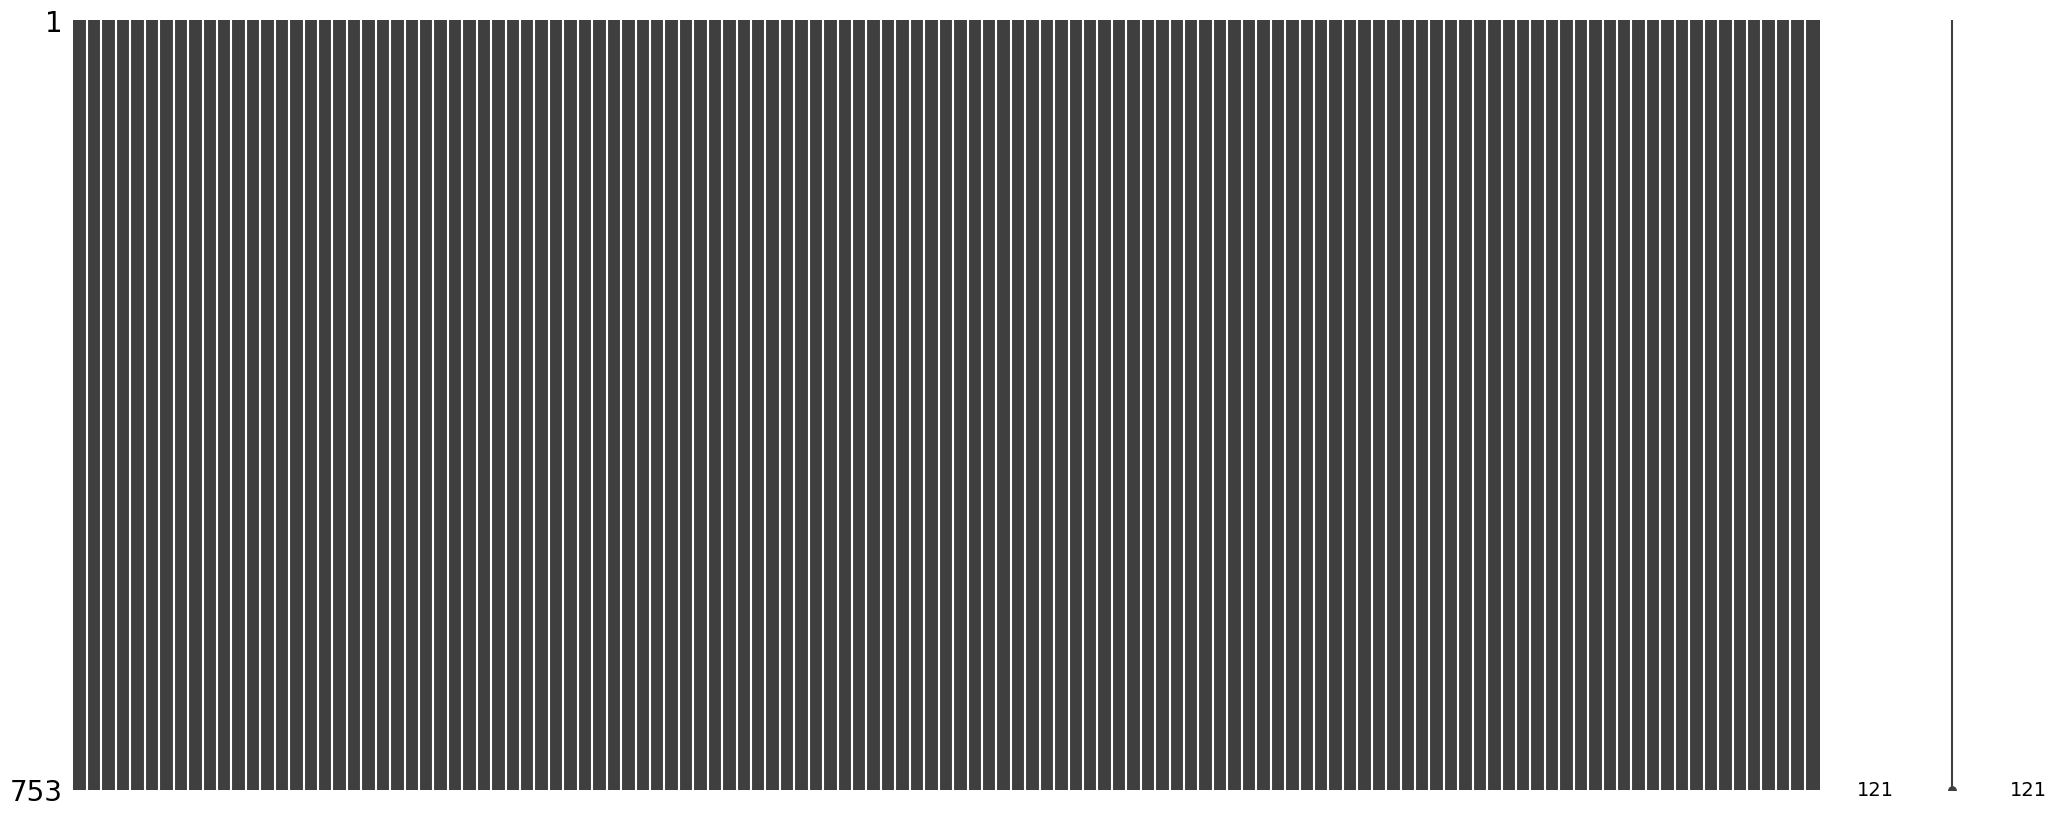

In [163]:
#Check to see how much is missing 
import missingno
missingno.matrix(data)

In [164]:
#removing all columns with more than 20% missing data 

print('Data Shape before cleaning =', data.shape)

missing_percentage = data.isnull().mean().sort_values(ascending=False)
missing_percentage.head(10)
dropped_list = sorted(list(missing_percentage[missing_percentage > 0.2].index))
data.drop(labels=dropped_list, axis=1, inplace=True)

print('Data Shape after cleaning =', data.shape)

Data Shape before cleaning = (753, 121)
Data Shape after cleaning = (753, 121)


In [165]:
# Fill NaN values with 0
data = data.fillna(0)

In [166]:
# Check if there are any NaN values in the DataFrame now
has_nan = data.isnull().values.any()
print(f"DataFrame contains NaN values: {has_nan}")

DataFrame contains NaN values: False


In [167]:
#Calculate returns and create a data frame
returns = data.pct_change().mean()*252
returns = pd.DataFrame(returns)
returns.columns = ['returns']

#Calculate the volatility
returns['volatility'] = data.pct_change().std()*np.sqrt(252)

data = returns
data

,returns,volatility
ticker,,
A,0.099,0.282
ABBV,0.193,0.207
ABT,0.046,0.228
AME,0.139,0.208
AMG,0.207,0.361
AMT,0.056,0.267
AMX,0.132,0.247
ANET,0.486,0.412
APH,0.183,0.235


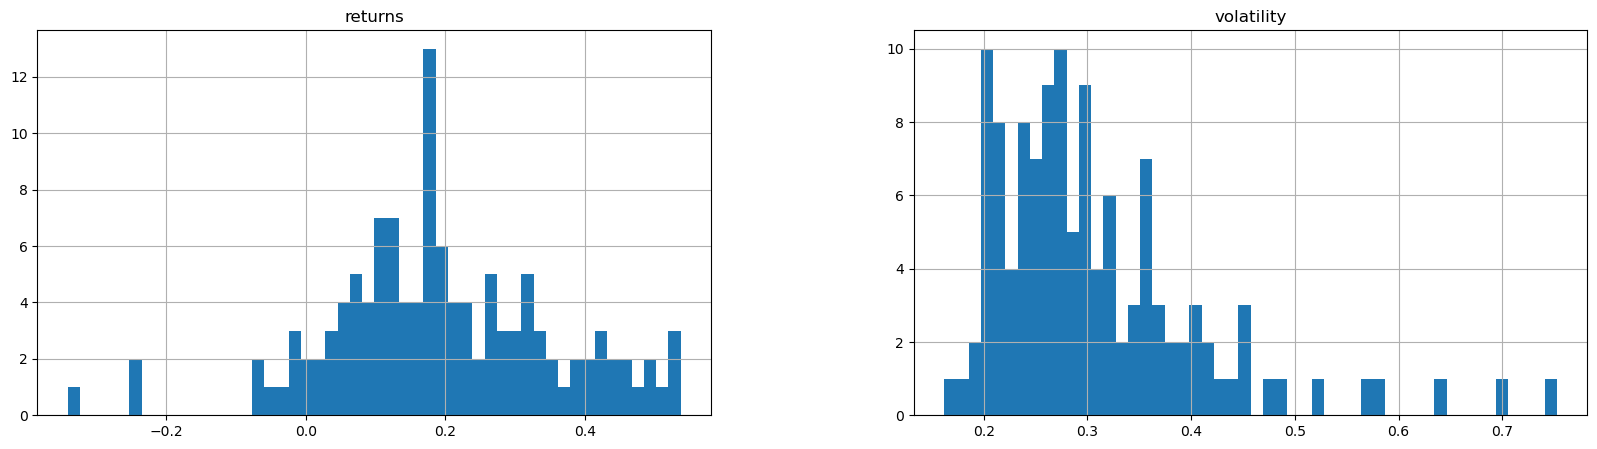

In [168]:
%matplotlib inline
data.hist(bins=50, figsize=(20,5))
plt.show()
# returns are not perfectly Gaussian(some fat tails & not N(0,1), so data needs standardising)

In [169]:
#some stocks have larger volatility than others 
#passing data with higher values into our models will be too noisey for the data with lower values 
#makes the algorithm not perform well so want to scale the variables (mean=0, variance =1)


from sklearn.preprocessing import StandardScaler

#Prepare the scaler
scale = StandardScaler().fit(data)

#Fit the scaler
scaled_data = pd.DataFrame(scale.fit_transform(data),columns = data.columns, index = data.index)
X = scaled_data
X.head()

,returns,volatility
ticker,,
A,-0.588,-0.255
ABBV,-0.010,-0.991
ABT,-0.917,-0.789
AME,-0.340,-0.978
AMG,0.076,0.510


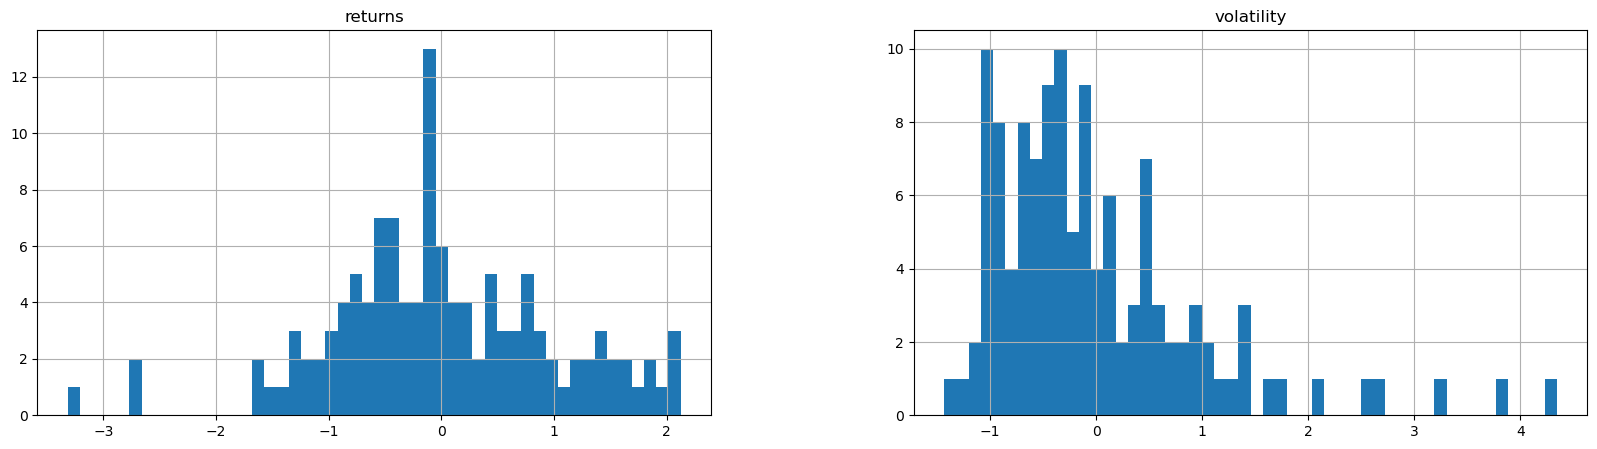

In [170]:
%matplotlib inline

X.hist(bins=50, figsize=(20,5))
plt.show()

# k-Means Clustering 

# Elbow Method

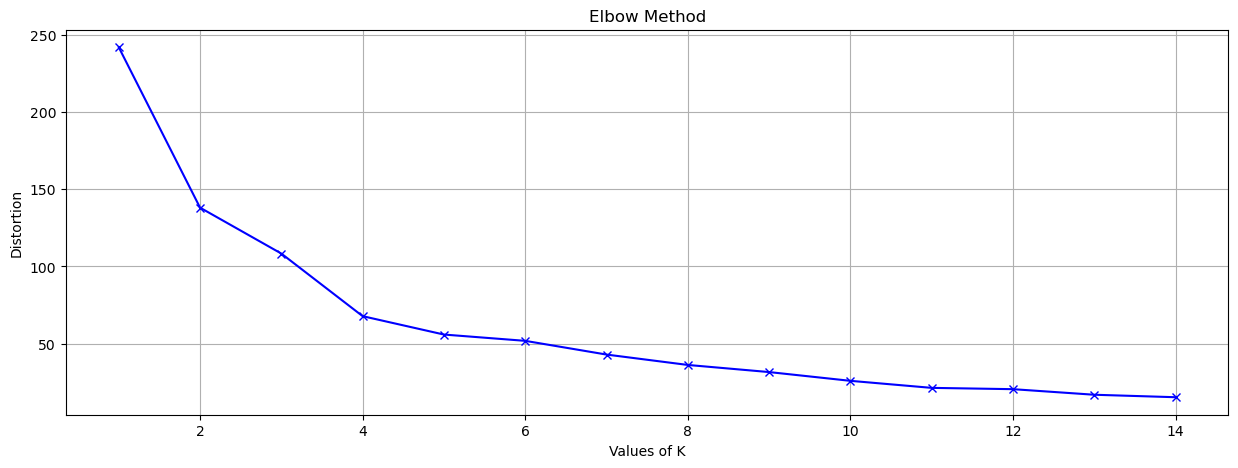

In [171]:
#obtain the number of k clusters used for Pairs Trading Problem 
#starting with elbow method 
#iterate through valus of k & calculate the distortion for each value of k 
#distortion & inertia for each value of k in the specified range 

#distortion average of squared distances from the center of each cluster 
#inertia is sum of squared distances of each feature to the closes cluster centre



from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

K = range(1,15)
distortions = []

#Fit the method
for k in K:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

#Plot the results
fig = plt.figure(figsize= (15,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

In [172]:
#pip install kneed
from kneed import KneeLocator
kl = KneeLocator(K, distortions, curve="convex", direction="decreasing")
kl.elbow

4

# Silhouette Method

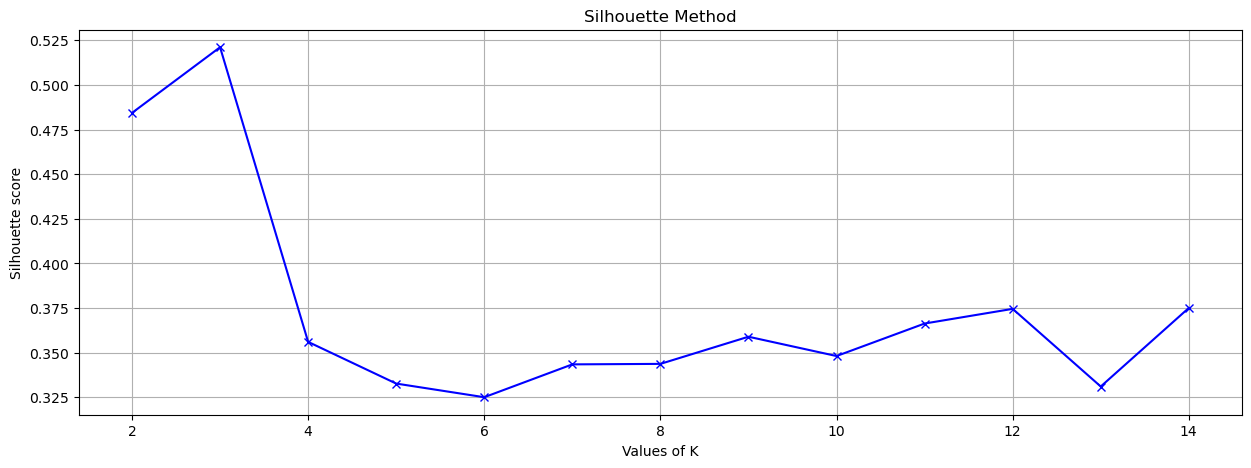

Suggested number of clusters:  2


In [173]:
#works by measuring how a particular instance is similar to the cluster is it put into
# values for this method are in the range b/w -1 to. 1 where higher values indicate better match 

from sklearn.metrics import silhouette_score

#For the silhouette method k needs to start from 2
K = range(2,15)
silhouettes = []

#Fit the method
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, init='random')
    kmeans.fit(X)
    silhouettes.append(silhouette_score(X, kmeans.labels_))

#Plot the results
fig = plt.figure(figsize= (15,5))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method')
plt.grid(True)
plt.show()

kl = KneeLocator(K, silhouettes, curve="convex", direction="decreasing")
print('Suggested number of clusters: ', kl.elbow)


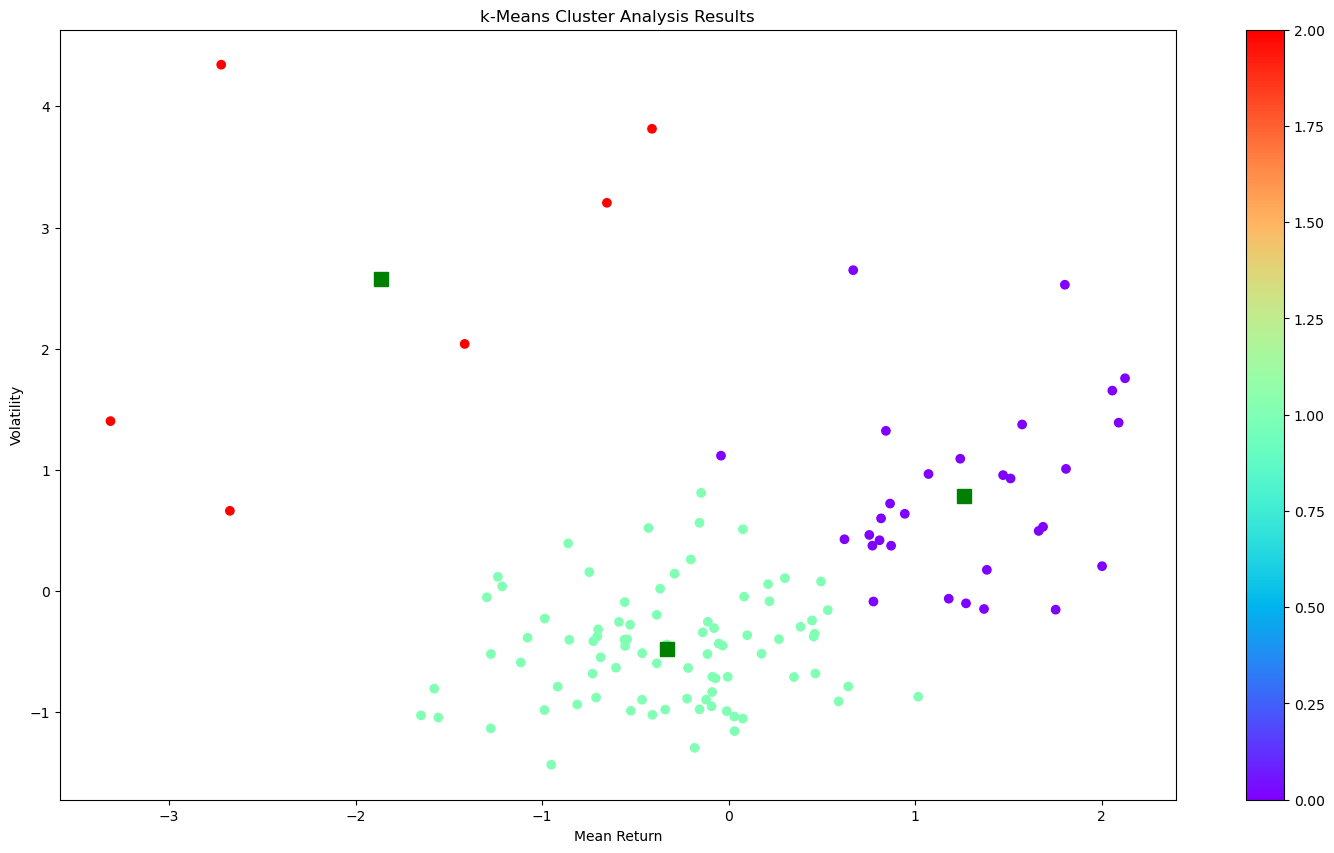

In [174]:
#2 methods show different optimal number of clusters 
#will go with number 3 
#building k-Means algorithm with 3 clusters 

c = 3
#Fit the model
k_means = KMeans(n_clusters=c)
k_means.fit(X)
prediction = k_means.predict(X)

#Plot the results
centroids = k_means.cluster_centers_
fig = plt.figure(figsize = (18,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c=k_means.labels_, cmap="rainbow", label = X.index)
ax.set_title('k-Means Cluster Analysis Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=10)
plt.show()

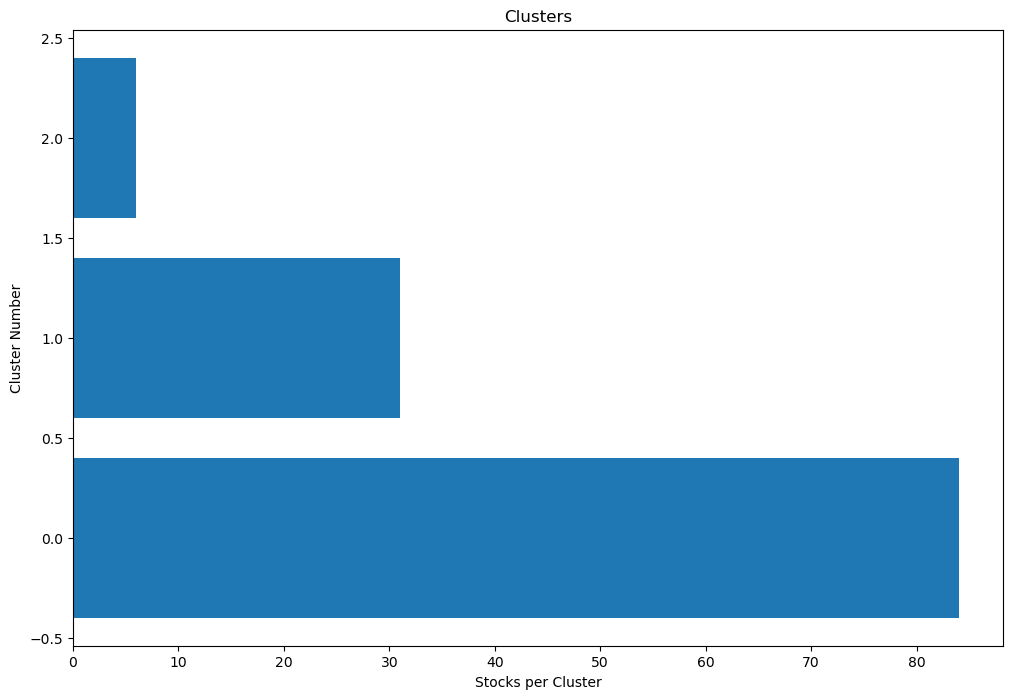

In [175]:
#leaving the outliers as they are so that we can know which stocks are these are.
#to know how many instances each cluster has 

clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]
plt.figure(figsize=(12,8))
plt.barh(range(len(clustered_series.value_counts())),clustered_series.value_counts())
plt.title('Clusters')
plt.xlabel('Stocks per Cluster')
plt.ylabel('Cluster Number')
plt.show()

# Hierarchial Clustering 

In [176]:
#method that groups features into clusters based on their similarity 
#perform groupage by agglomerative (bottom up) or divisive (top-down) approach 
#main advantage: doesnt require us to specify the number of clusters in advance 
#method performs clustering by creating a tree of clusters by grouping & separating features on each iteration
#product of clustering process is visualised in figure => dendrogram


In [177]:
#Ward linkage – it works by minimizing the within-cluster variance of the clusters that are in the process of merging.
#Average linkage – it calculates the average distance between each data point in two clusters.
#Complete linkage – measures the maximum distance between all data points in two clusters.
#Single linkage – groups the clusters in a bottom-up way.

In [178]:
#objective: minimize the variance distance b/w our clusters 

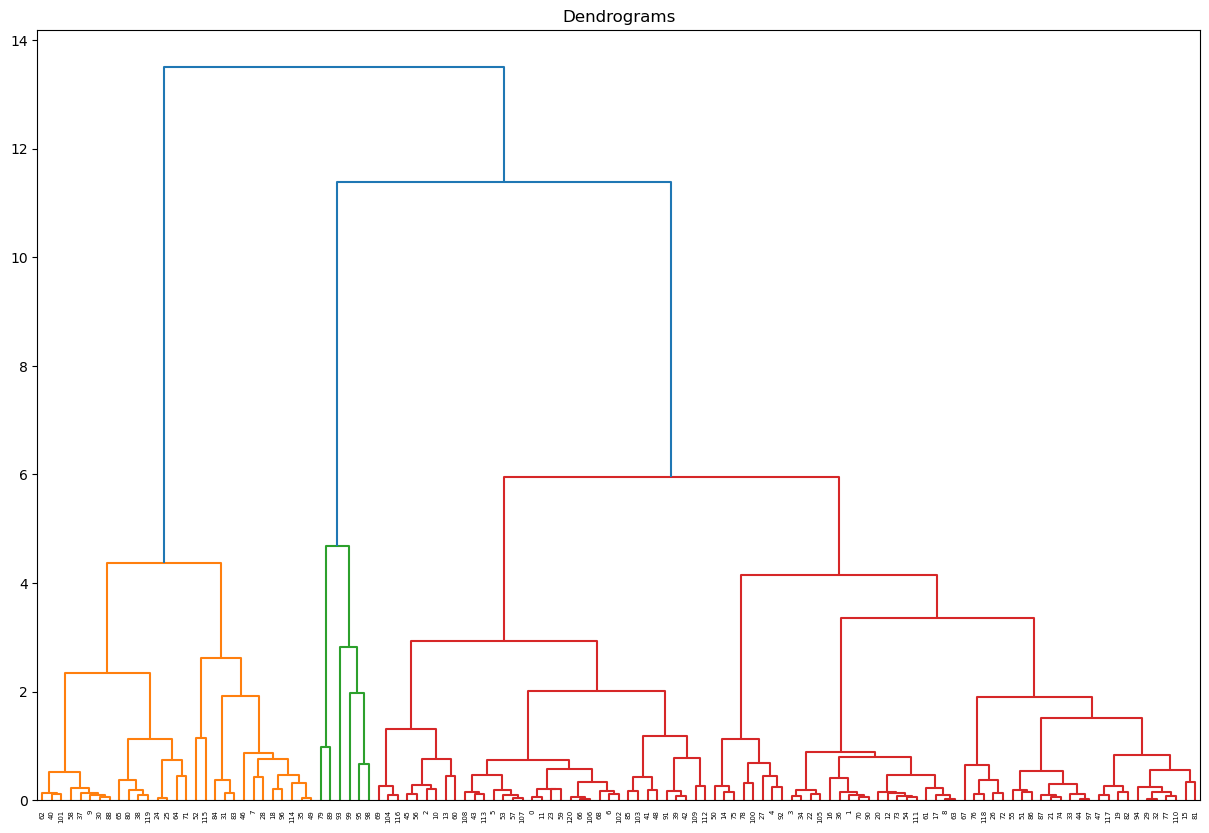

In [179]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(15, 10))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X, method='ward'))

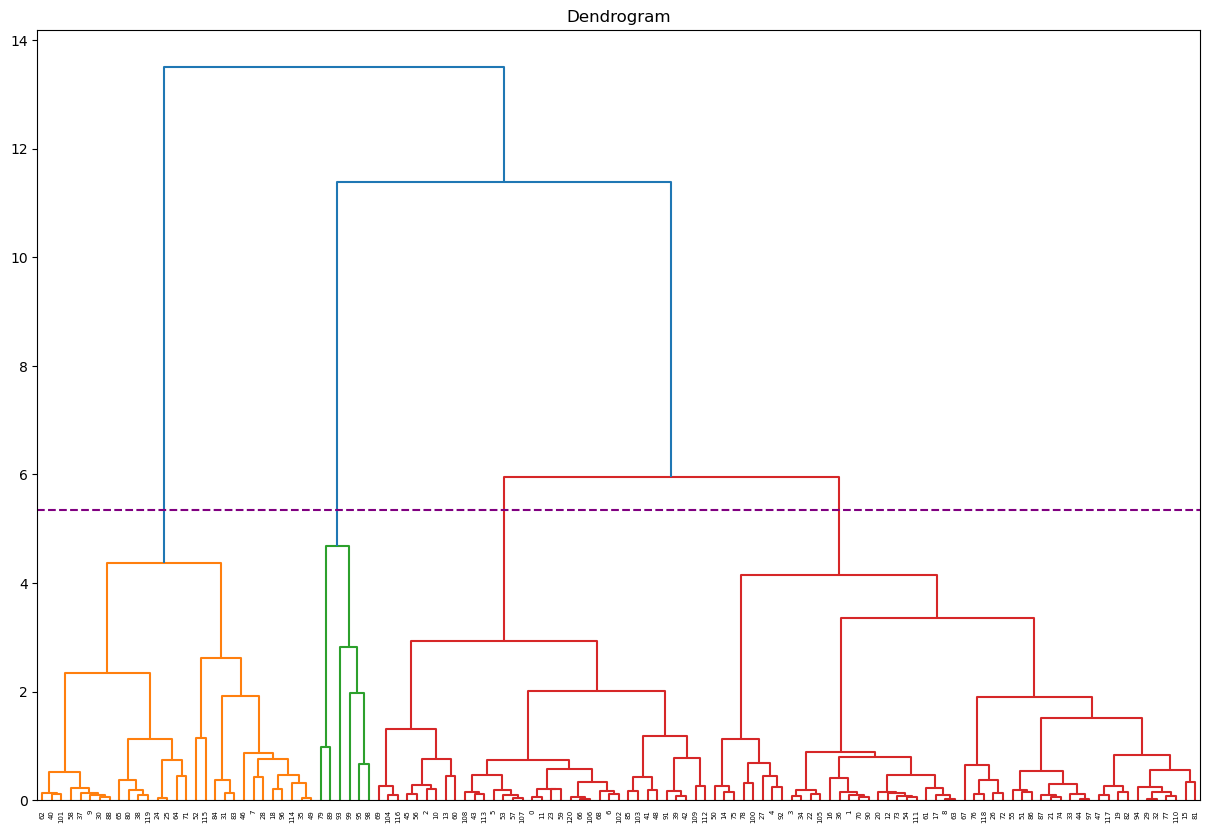

In [180]:
#a cut at 5 will give 4 clusters 
plt.figure(figsize=(15, 10))  
plt.title("Dendrogram")  
dend = shc.dendrogram(shc.linkage(X, method='ward'))
plt.axhline(y=5.35, color='purple', linestyle='--')

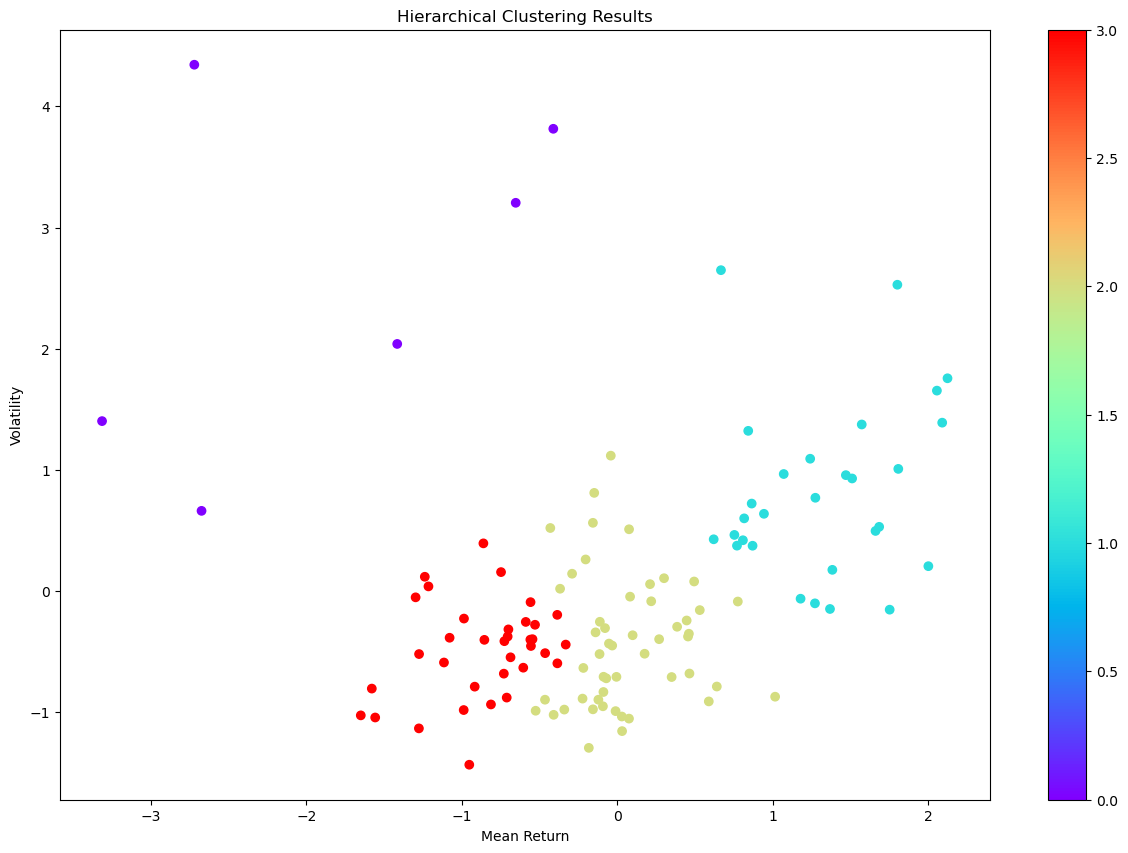

In [181]:
#now we know the number of clusters, we can fit the hierarchial clustering model to our data 
#obtain a scatter plot where the clustering output instances can be clearly seen 
#Fit the model
clusters = 4
hc = AgglomerativeClustering(n_clusters= clusters, metric='euclidean', linkage='ward')
labels = hc.fit_predict(X)

#Plot the results
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=labels, cmap='rainbow')
ax.set_title('Hierarchical Clustering Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.show()

# Affinity Propagation Clustering

In [182]:
#method that creates clusters by a criterion of how well suited an instacnce is to be a representative of another one
#doesnt require a specified number of clusters in advance 

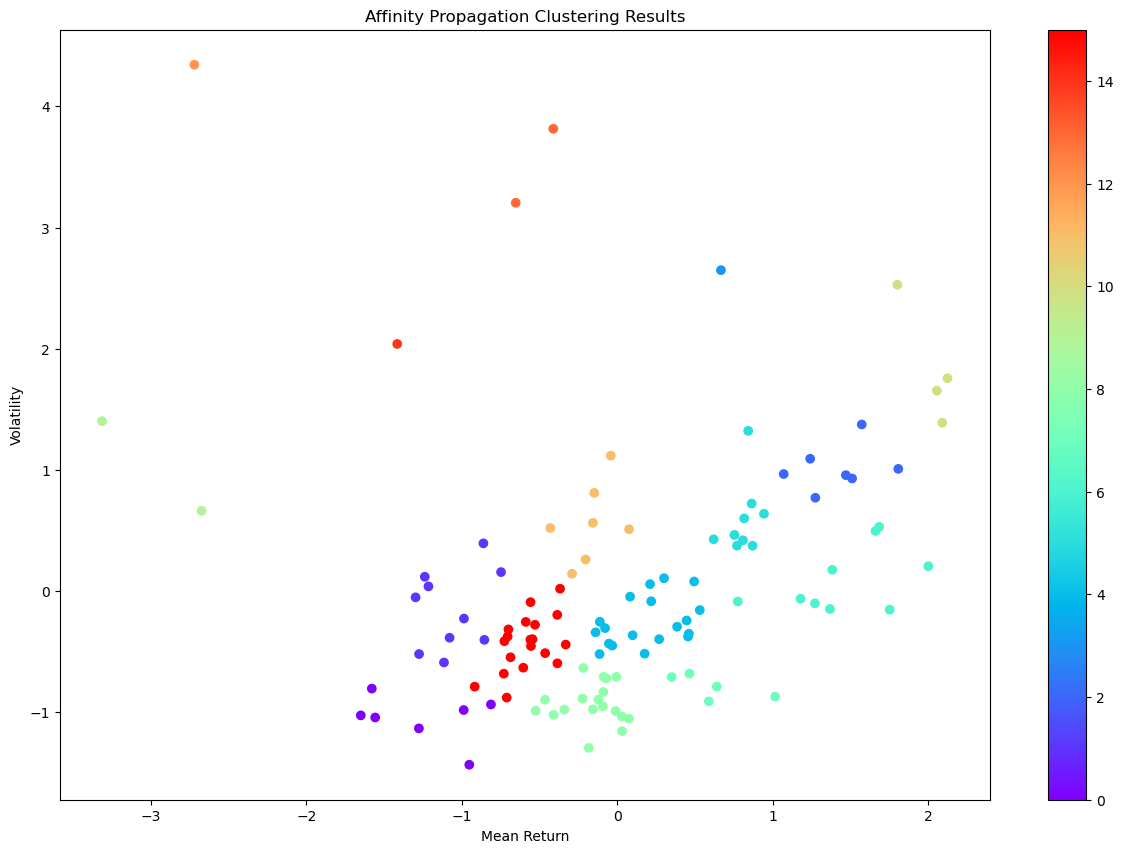

In [183]:
from sklearn.cluster import AffinityPropagation

#Fit the model
ap = AffinityPropagation()
ap.fit(X)
labels1 = ap.predict(X)

#Plot the results
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=labels1, cmap='rainbow')
ax.set_title('Affinity Propagation Clustering Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.show()

In [184]:
#obtaining their number & arrange them for better look
#do the above by taking the cluster centre indices & labels & plotting them 

The number of clusters is: 16


<Figure size 640x480 with 0 Axes>

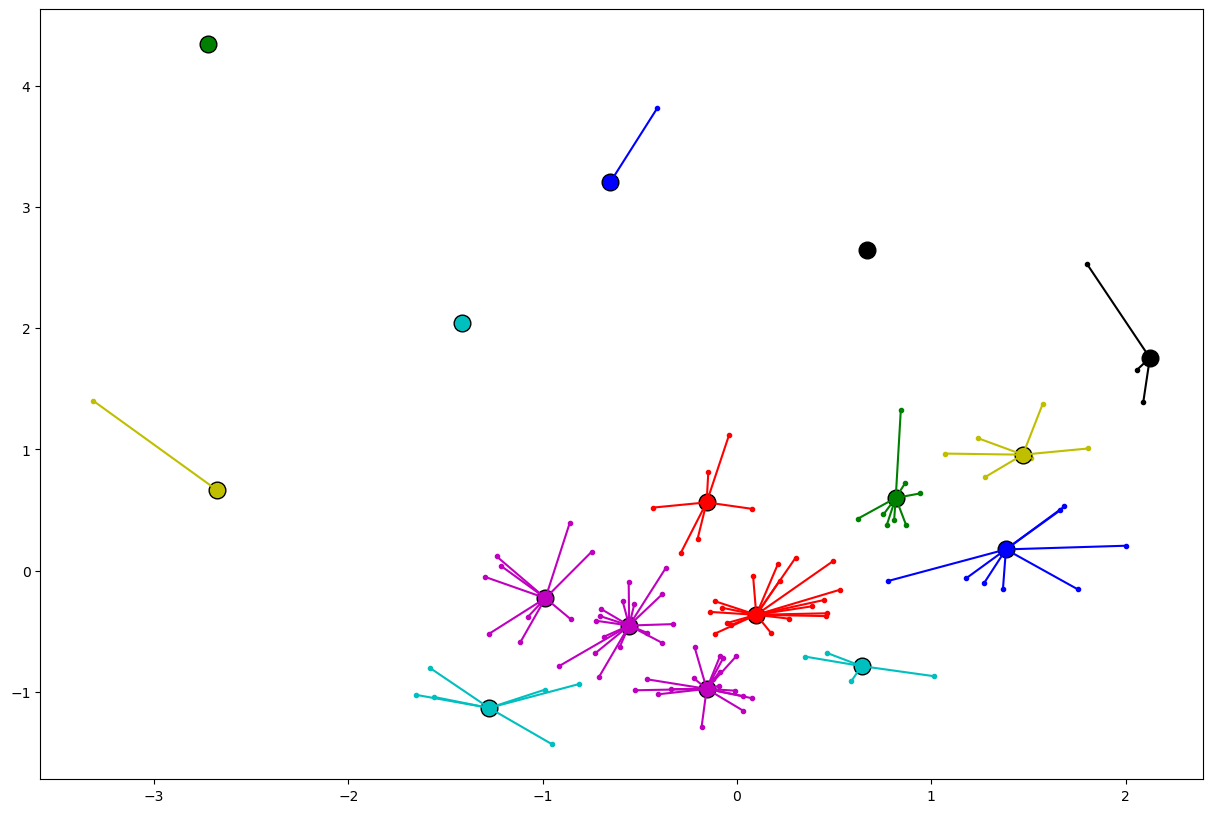

In [185]:
from itertools import cycle

#Extract the cluster centers and labels
cci = ap.cluster_centers_indices_
labels2 = ap.labels_

#Print their number
clusters = len(cci)
print('The number of clusters is:',clusters)

#Plot the results
X_ap = np.asarray(X)
plt.close('all')
plt.figure(1)
plt.clf
fig=plt.figure(figsize=(15,10))
colors = cycle('cmykrgbcmykrgbcmykrgbcmykrgb')
for k, col in zip(range(clusters),colors):
    cluster_members = labels2 == k
    cluster_center = X_ap[cci[k]]
    plt.plot(X_ap[cluster_members, 0], X_ap[cluster_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=12)
    for x in X_ap[cluster_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.show()

# Evaluation & Comparison Of Clustering Models 

In [186]:
#as clustering models are unsupevised, meaning we dont't have labels
#compare the models by their silhouette score 

In [187]:
print("k-Means Clustering", metrics.silhouette_score(X, k_means.labels_, metric='euclidean'))
print("Hierarchical Clustering", metrics.silhouette_score(X, hc.fit_predict(X), metric='euclidean'))
print("Affinity Propagation Clustering", metrics.silhouette_score(X, ap.labels_, metric='euclidean'))

k-Means Clustering 0.5211653802451607
Hierarchical Clustering 0.34443952649782483
Affinity Propagation Clustering 0.3877021178222344


# Extracting The Trading Pairs 

In [188]:
#k-Means algorithm performed the best among the 3 

In [189]:
#in order to extract, need to check how many trading pairs are there to be evaluated 
#evaluation will perform statistical analysis to find pairs that are cointegrated 
#pairs that are deemed as cointegrated when they aren't stationary & tend to move together 


cluster_size_limit = 1000
counts = clustered_series.value_counts()
ticker_count = counts[(counts>1) & (counts<=cluster_size_limit)]
print ("Number of clusters: %d" % len(ticker_count))
print ("Number of Pairs: %d" % (ticker_count*(ticker_count-1)).sum())

Number of clusters: 3
Number of Pairs: 7932


# Co-Integrated Pairs 

In [190]:
data1 = data.copy()

In [191]:
data1 = pd.read_csv('30_Stocks_4_Sectors')

In [192]:
def find_cointegrated_pairs(data, significance=0.05):
    n = data.shape[1]    
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(1):
        for j in range(i+1, n):
            S1 = data[keys[i]]            
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [193]:
#looking for cointegrated pairs within the clusters & return them
from statsmodels.tsa.stattools import coint

cluster_dict = {}

for i, clust in enumerate(ticker_count.index):
    tickers = clustered_series[clustered_series == clust].index
    score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(data1[tickers])
    cluster_dict[clust] = {}
    cluster_dict[clust]['score_matrix'] = score_matrix
    cluster_dict[clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[clust]['pairs'] = pairs
    
pairs = []   
for cluster in cluster_dict.keys():
    pairs.extend(cluster_dict[cluster]['pairs'])
    
print ("Number of pairs:", len(pairs))
print ("In those pairs, we found %d unique tickers." % len(np.unique(pairs)))
print(pairs)

Number of pairs: 1
In those pairs, we found 2 unique tickers.
[('A', 'GS')]


# Visualising Using TSNE (t-distributed stochastic neighbor embedding)

In [194]:
#used for visualizing high dimensional data by giving each instance a location in a 2d or 3d map 

In [195]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm

stocks = np.unique(pairs)
X_data = pd.DataFrame(index=X.index, data=X).T
in_pairs_series = clustered_series.loc[stocks]
stocks = list(np.unique(pairs))
X_pairs = X_data.T.loc[stocks]
X_pairs.head()

,returns,volatility
ticker,,
A,-0.588,-0.255
GS,-0.053,-0.434


In [196]:
X_tsne = TSNE(learning_rate=30, perplexity=1, random_state=42, n_jobs=-1).fit_transform(X_pairs)
X_tsne

array([[ 1.3048959e+03, -9.5333858e-21],
       [-1.3048959e+03, -9.5333858e-21]], dtype=float32)

/var/folders/jh/y6bv24852zl7bfq_mmz4fkd80000gn/T/ipykernel_2042/3774293952.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3, c='b');


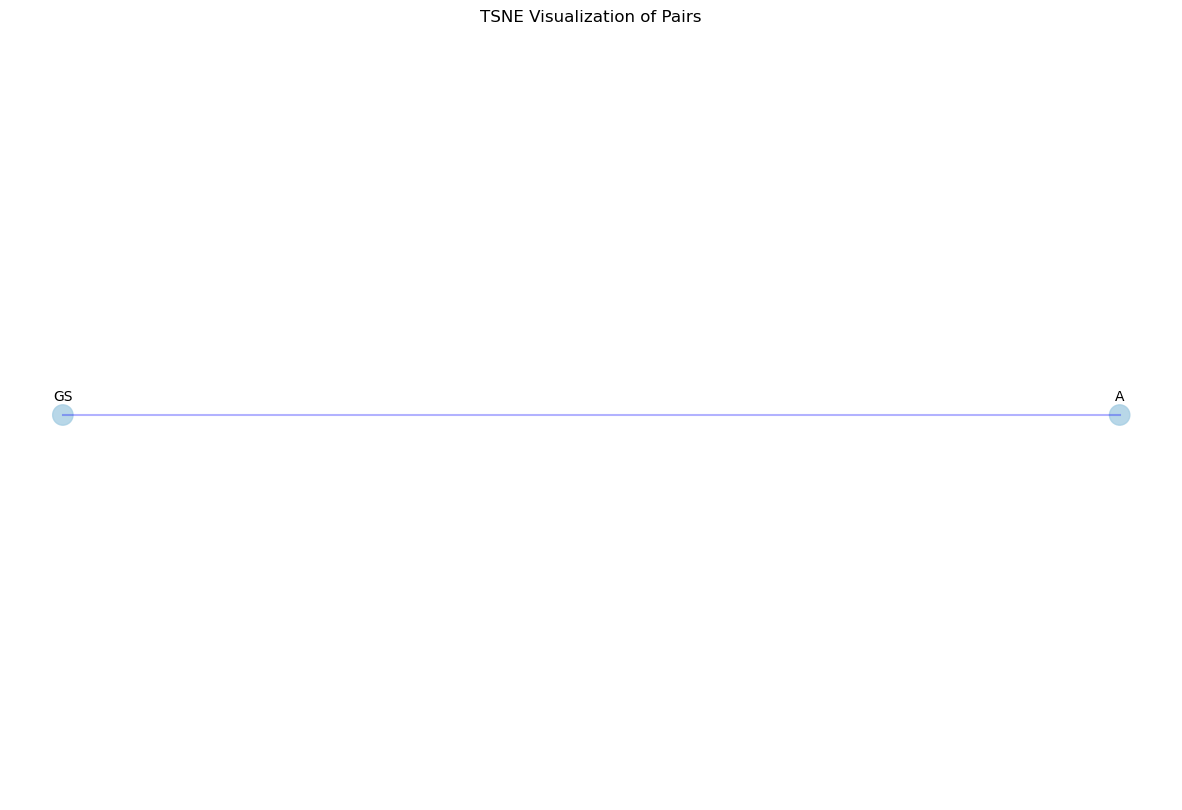

In [197]:
plt.figure(1, facecolor='white',figsize=(15,10))
plt.clf()
plt.axis('off')
for pair in pairs:
    ticker1 = pair[0]
    loc1 = X_pairs.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]
    ticker2 = pair[0]
    loc2 = X_pairs.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3, c='b');
    
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=215, alpha=0.8, c=in_pairs_series.values, cmap=cm.Paired)
plt.title('TSNE Visualization of Pairs'); 

# Join pairs by x and y
for x,y,name in zip(X_tsne[:,0],X_tsne[:,1],X_pairs.index):

    label = name

    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center')
    
plt.show()